# Crop Yield Prediction: XGBoost

In [32]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna visualization tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Making the plots look nice (standard setup)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Prep and Crop Choice
I'm loading the cleaned dataset (Part 3 parquet file) and setting the prediction target to **Rice**. I'll also clean up any rows that are missing the target yield.

In [33]:
# Loading the parquet file
df = pd.read_parquet('Parquet/XY_v3.parquet')

# Checking what crops we have
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("Crops available:", available_crops)
print("-" * 30)

# --- SETTING THE CROP HERE ---
CHOSEN_CROP = 'rice' 
# -----------------------------

TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y' # Keeping this lag feature for the model, it's usually important

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found. Check spelling.")

print(f"Target Variable: {TARGET_COL}")

# Dropping rows where the target is missing (can't train on those)
df_model = df.dropna(subset=[TARGET_COL])

print(f"Rows ready for training: {len(df_model)}")

Crops available: ['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
------------------------------
Target Variable: Y_rice
Rows ready for training: 4687


### 2. Splitting the Data
Since this is **time-series data**, I need to split the data by year. This makes sure the model isn't predicting an earlier year using data it wouldn't have known yet:

* **Train:** Data before 2014.
* **Validation:** Data from 2014-2018 (used for tuning).
* **Test:** Data from 2019+ (used for the final score).

In [34]:
# Cleaning up: Removing lag features that belong to other crops
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- Remove min/max TARGET_COL rows per country (robust version) ---
df_model = df_model.copy()

# Get row positions (not index labels)
idx_min = df_model.groupby('area')[TARGET_COL].idxmin().values
idx_max = df_model.groupby('area')[TARGET_COL].idxmax().values

# Combine them safely
rows_to_drop = np.concatenate([idx_min, idx_max])

# Drop by position, not by label
df_model = df_model.iloc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)


# Defining my X (features)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Number of features: {len(feature_cols)}")
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# Training set
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# Validation set
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# Test set
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTrain size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

Number of features: 17


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Train size: 3383
Val size:   541
Test size:  517


In [35]:
X_train.head()

,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,2241.4,2207.10,2181.766667,325.32,154.391016,59.402942,NaN,NaN,NaN,11.699167,-33.899342,-60.110408,NaN,5.778887,34.53,69.17
1,1983,2199.4,2220.40,2204.533333,373.54,186.787027,72.870980,NaN,NaN,NaN,10.650833,-42.640609,-60.922614,NaN,6.672946,34.53,69.17
2,1984,2258.1,2228.75,2232.966667,273.25,211.709895,-21.830163,NaN,NaN,NaN,11.383333,-46.025539,-55.929678,NaN,7.152971,34.53,69.17
3,1985,2241.6,2249.85,2233.033333,196.10,96.438281,33.467341,19.215833,-13.475498,-51.480910,11.888333,-39.599910,-69.677748,NaN,9.178255,34.53,69.17
4,1986,2248.2,2244.90,2249.300000,155.09,67.530475,38.964517,18.741667,-12.861915,-47.249218,12.511667,-31.144849,-60.631870,NaN,9.224020,34.53,69.17


### 3. Initial Model
I'm setting up a standard XGBoost model first, just to see what kind of baseline score I can get before tuning. I'm using `early_stopping` to keep it from overfitting to the training data.

[0]	validation_0-rmse:1823.04204	validation_1-rmse:2255.38585
[100]	validation_0-rmse:867.51254	validation_1-rmse:1067.28429
[200]	validation_0-rmse:572.73404	validation_1-rmse:664.64456
[300]	validation_0-rmse:482.01470	validation_1-rmse:510.48123
[400]	validation_0-rmse:454.31199	validation_1-rmse:461.07830
[500]	validation_0-rmse:442.38693	validation_1-rmse:444.31131
[600]	validation_0-rmse:434.33283	validation_1-rmse:440.12798
[700]	validation_0-rmse:427.75443	validation_1-rmse:439.23618
[736]	validation_0-rmse:425.66160	validation_1-rmse:439.37230


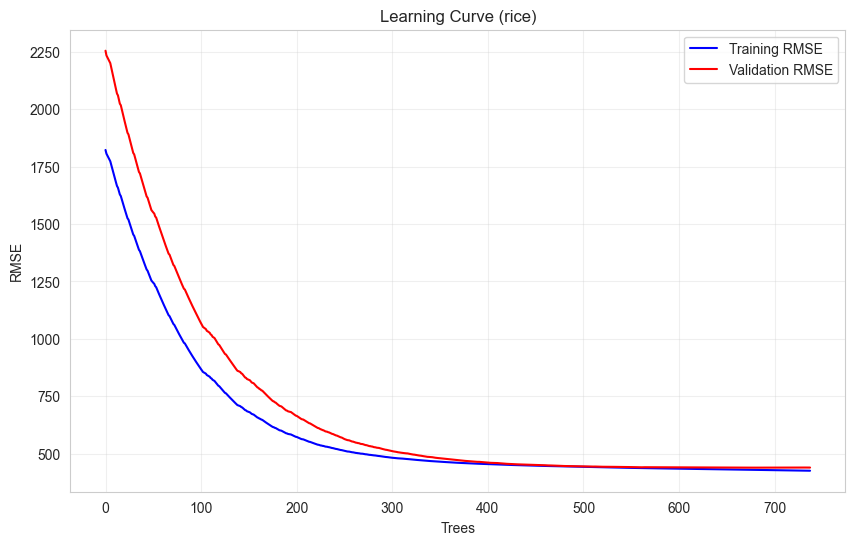

  Metric     Train  Validation      Test
0   RMSE  428.5755    438.8652  449.3758
1     R²    0.9457      0.9592    0.9568


In [36]:
# --- INITIAL MODEL TRAINING ---

model_init = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=4,
    subsample=0.7,
    colsample_bytree=0.4,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)


# Fitting the model
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=100  # print progress every 100 trees
)

# Getting results for the plot
results = model_init.evals_result()

# --- PLOTTING LEARNING CURVE ---
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'Learning Curve ({CHOSEN_CROP})')
    plt.xlabel('Trees')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Train predictions
y_pred_init_train = model_init.predict(X_train)
rmse_init_train = np.sqrt(mean_squared_error(y_train, y_pred_init_train))
r2_init_train = r2_score(y_train, y_pred_init_train)

# Validation predictions
y_pred_init_val = model_init.predict(X_val)
rmse_init_val = np.sqrt(mean_squared_error(y_val, y_pred_init_val))
r2_init_val = r2_score(y_val, y_pred_init_val)

# Test predictions
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

# --- Create table ---
metrics_table_init = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_init_train, r2_init_train],
    'Validation': [rmse_init_val, r2_init_val],
    'Test': [rmse_init_test, r2_init_test]
})

# Round for readability
metrics_table_init = metrics_table_init.round(4)

print(metrics_table_init)


### 4. Tuning with Optuna
The initial model seems okay, but I think I can improve the score by finding better hyperparameter settings. I'll run **Optuna** for 50 trials to try different combinations of learning rates, depths, and regularization.

In [37]:
# Defining the objective function for Optuna (relaxed search space)
def objective(trial):
    params = {
        "n_estimators": 1000,

        # learning rate slightly wider around best
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.012),

        # max_depth relaxed a bit
        "max_depth": trial.suggest_int("max_depth", 2, 4),

        # min_child_weight relaxed
        "min_child_weight": trial.suggest_int("min_child_weight", 4, 7),

        # subsample and colsample_bytree slightly wider
        "subsample": trial.suggest_float("subsample", 0.68, 0.78),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.41, 0.45),

        # regularization still small, but slightly wider range
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-4, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e-3, log=True),

        "random_state": 42,
        "n_jobs": -1,
        "early_stopping_rounds": 50
    }


    model = xgb.XGBRegressor(**params)
    
    # Training on train set, evaluating on validation set
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# Running the study
study_name = f'{CHOSEN_CROP}_optimization'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=100)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-09 15:05:43,081] A new study created in memory with name: rice_optimization
[I 2025-12-09 15:05:43,812] Trial 0 finished with value: 437.5247870346131 and parameters: {'learning_rate': 0.009124591395585632, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.6989865367051858, 'colsample_bytree': 0.4376596147601876, 'reg_alpha': 2.9285071118788973e-08, 'reg_lambda': 6.255425355278782e-06}. Best is trial 0 with value: 437.5247870346131.
[I 2025-12-09 15:05:44,348] Trial 1 finished with value: 439.18582351712166 and parameters: {'learning_rate': 0.011166847701367657, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.7316862825567712, 'colsample_bytree': 0.42229324524394246, 'reg_alpha': 2.8912773214458785e-06, 'reg_lambda': 4.4020536071687453e-07}. Best is trial 0 with value: 437.5247870346131.
[I 2025-12-09 15:05:44,970] Trial 2 finished with value: 449.670459756027 and parameters: {'learning_rate': 0.011462179867764329, 'max_depth': 4, 'min_child_weight': 6, 'subsample'


Best Parameters found:
{'learning_rate': 0.00980106249190904, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.7454296586941284, 'colsample_bytree': 0.43067927471467143, 'reg_alpha': 1.763543358173082e-05, 'reg_lambda': 2.4290447841117843e-08}


### 5. Visualization
These plots show how the tuning went and which parameters were most important. It looks like Optuna found a few good combinations early on.

In [38]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_XGBoost"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 6. Final Model
I'm training the final version now. Since tuning is finished, I can **combine the Training and Validation sets** to give the model as much historical data as possible. Then I'll test it on the unseen Test set.

[0]	validation_0-rmse:1887.57337	validation_1-rmse:2239.66787
[100]	validation_0-rmse:940.08841	validation_1-rmse:1094.80858
[200]	validation_0-rmse:611.01314	validation_1-rmse:663.35474
[300]	validation_0-rmse:500.58995	validation_1-rmse:503.01145
[400]	validation_0-rmse:466.61556	validation_1-rmse:447.80307
[500]	validation_0-rmse:456.05383	validation_1-rmse:432.19065
[600]	validation_0-rmse:451.13835	validation_1-rmse:427.45452
[700]	validation_0-rmse:447.46082	validation_1-rmse:425.87300
[800]	validation_0-rmse:444.56665	validation_1-rmse:424.67990
[900]	validation_0-rmse:441.98998	validation_1-rmse:424.02143
[999]	validation_0-rmse:439.73834	validation_1-rmse:423.86400


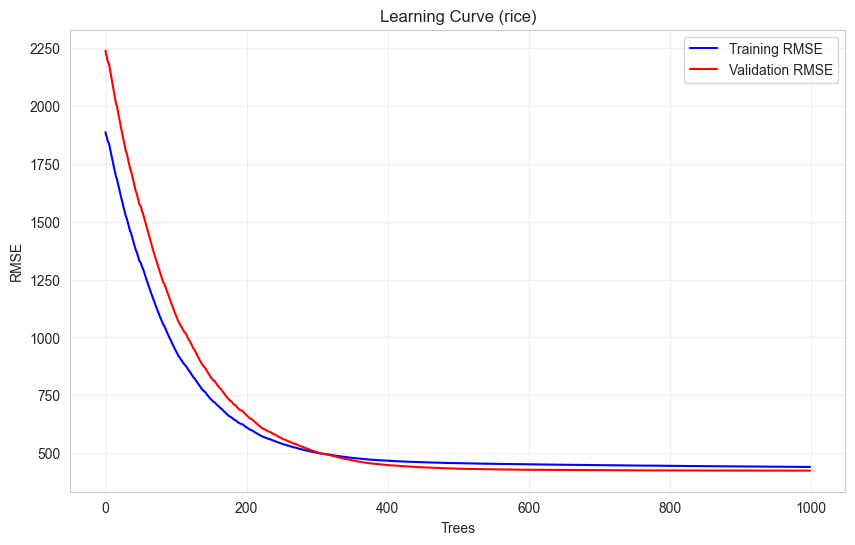

  Metric     Train  Validation      Test
0   RMSE  448.0227    392.9166  423.4506
1     R²    0.9407      0.9673    0.9617


In [39]:
# Merging train and val for the final model training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Setting up params (reusing best params found by Optuna)
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['early_stopping_rounds'] = 50

final_model = xgb.XGBRegressor(**best_params)

# Training on the full history
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    verbose=100
)

results = final_model.evals_result()

# --- PLOTTING LEARNING CURVE ---
# Checking the curve one last time for the full training data
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'Learning Curve ({CHOSEN_CROP})')
    plt.xlabel('Trees')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Train predictions
y_pred_final_train = final_model.predict(X_train)
rmse_final_train = np.sqrt(mean_squared_error(y_train, y_pred_final_train))
r2_final_train = r2_score(y_train, y_pred_final_train)

# Validation predictions
y_pred_final_val = final_model.predict(X_val)
rmse_final_val = np.sqrt(mean_squared_error(y_val, y_pred_final_val))
r2_final_val = r2_score(y_val, y_pred_final_val)

# Test predictions
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

# --- Create table ---
metrics_table_final = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_final_train, r2_final_train],
    'Validation': [rmse_final_val, r2_final_val],
    'Test': [rmse_final_test, r2_final_test]
})

# Round for readability
metrics_table_final = metrics_table_final.round(4)

print(metrics_table_final)

### 7. Results Comparison
Let's see if the tuning actually helped. I'm comparing the RMSE of the Initial Model (default settings) vs. the Tuned Model (best settings found by Optuna).

--- Final Test Set Results ---
Initial Model: RMSE=449.38, R2=0.9568
Tuned Model:   RMSE=423.45, R2=0.9617
Improvement:   5.77%


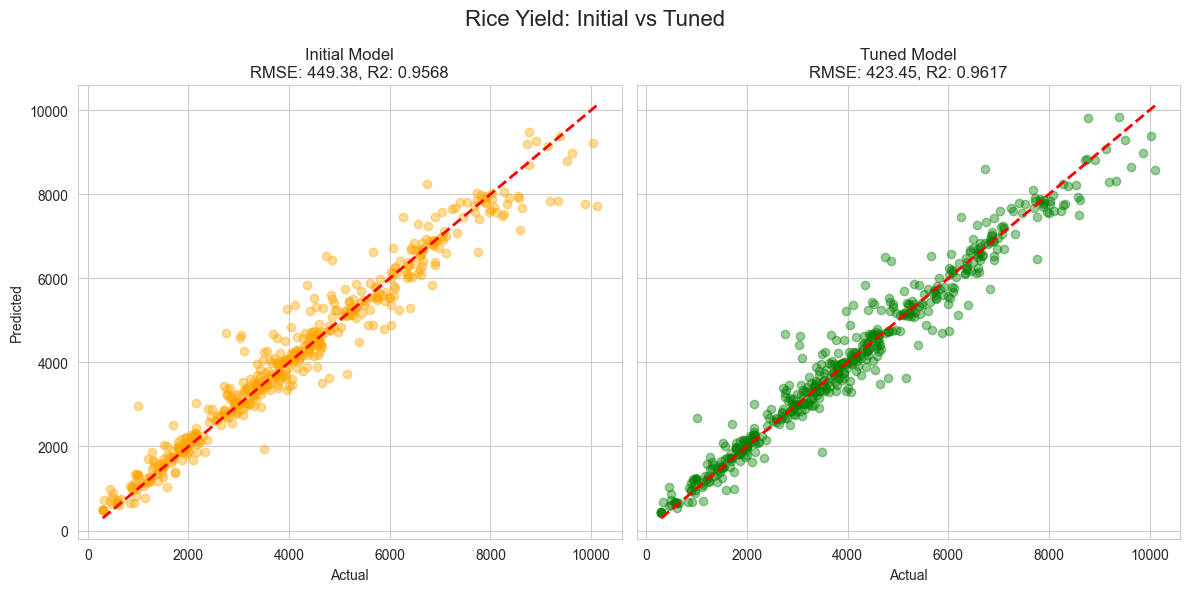

In [40]:
# Calculate improvement of Tuned Model over the Initial Model
imp_final = (rmse_init_test - rmse_final_test) / rmse_init_test * 100

print("--- Final Test Set Results ---")
print(f"Initial Model: RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:   RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f}")
print(f"Improvement:   {imp_final:.2f}%")

# --- PLOTTING ---
# Plotting the two models side-by-side (Initial and Tuned)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Setting axis limits so they match on both plots
all_preds = np.concatenate([y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# Initial Model Plot
axes[0].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(
    f'Initial Model\nRMSE: {rmse_init_test:.2f}, R2: {r2_init_test:.4f}'
)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Tuned Model Plot
axes[1].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(
    f'Tuned Model\nRMSE: {rmse_final_test:.2f}, R2: {r2_final_test:.4f}'
)
axes[1].set_xlabel('Actual')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Initial vs Tuned', fontsize=16)
plt.tight_layout()
plt.show()

### 8. Trend Analysis
I'll visualize how the model performed over the years. This helps check if it captures the general ups and downs.

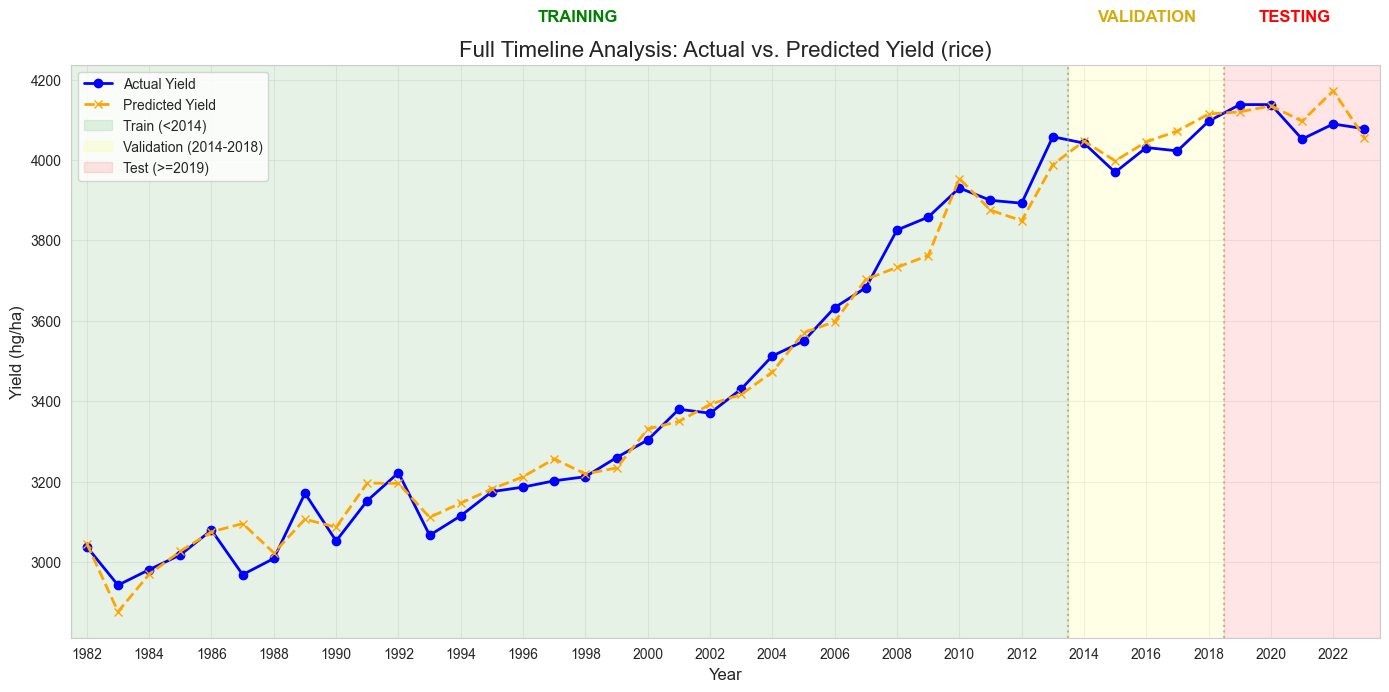

In [41]:

# 1. Predictions
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Build DataFrame
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# 3. Aggregate yearly
yearly_trend = df_full_trend.groupby('Year').mean()

# 4. Plot
plt.figure(figsize=(14, 7))

# Plot lines
plt.plot(yearly_trend.index, yearly_trend['Actual'],
         marker='o', label='Actual Yield', linewidth=2, color='blue')

plt.plot(yearly_trend.index, yearly_trend['Predicted'],
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded Regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1,
            label=f'Train (<{TRAIN_END_YEAR})')

plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1,
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')

plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1,
            label=f'Test (>={VAL_END_YEAR})')

# --- Split Lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING',
         ha='center', fontsize=12, fontweight='bold', color='green')

plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION',
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')

plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING',
         ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final Styling ---
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()


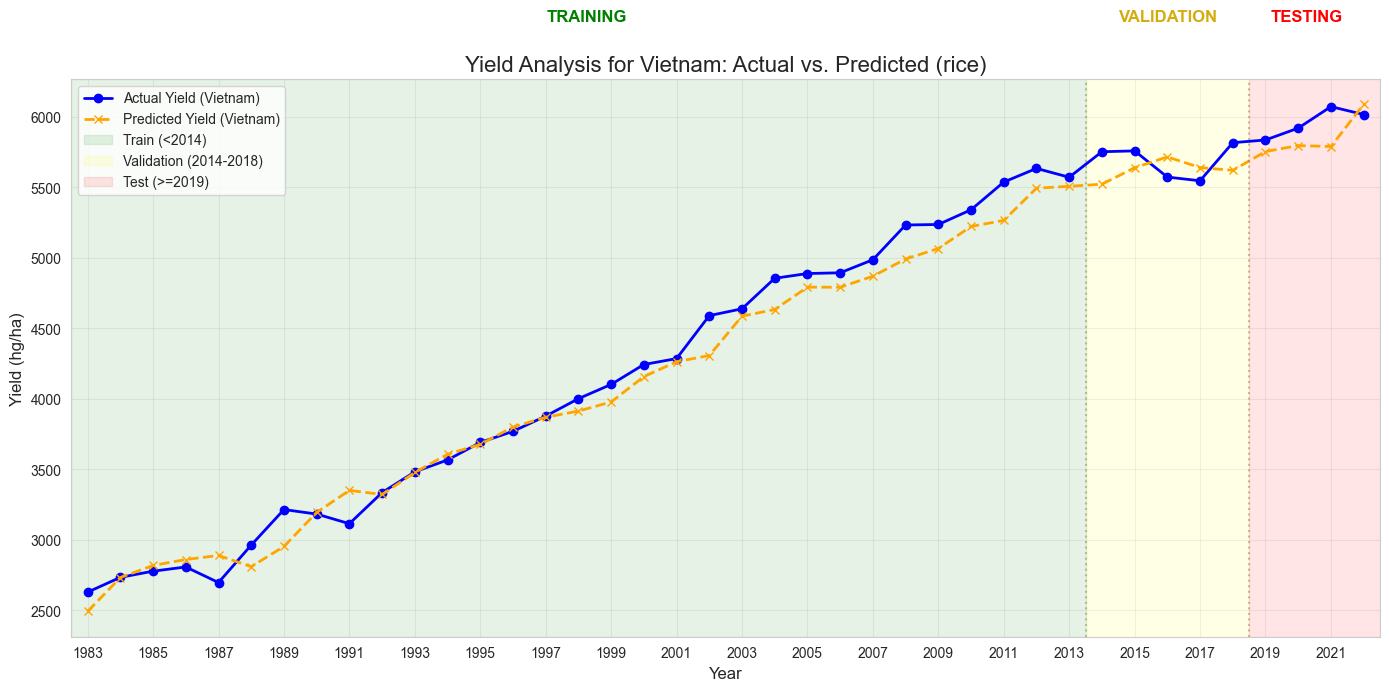

In [42]:
# --- Add country column ---
df_full_trend['Area'] = df_model['area']

# --- Country-specific trend ---
TARGET_COUNTRY = "Vietnam"
df_country = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]
country_trend = df_country.groupby('Year')[['Actual', 'Predicted']].mean()

# --- Plot ---
plt.figure(figsize=(14, 7))

# Country lines
plt.plot(country_trend.index, country_trend['Actual'],
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2, color='blue')
plt.plot(country_trend.index, country_trend['Predicted'],
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = country_trend.index.min()
MAX_YEAR = country_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR-1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# --- Split lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = country_trend['Actual'].max()
text_y = y_max * 1.1

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final styling ---
plt.title(f'Yield Analysis for {TARGET_COUNTRY}: Actual vs. Predicted ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)
plt.tight_layout()
plt.show()


### 9. Geographic Error Map
I want to see where the model makes the biggest mistakes. I'll map the error (RMSPE) by country.

In [43]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- 1. Prepare the test DataFrame ---
mask_test = df_model['year'] >= VAL_END_YEAR
test_context = df_model[mask_test][['area', 'year']]

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# Join back country info
comparison_df = comparison_df.join(test_context)

# --- 2. Filter only the latest year per country ---
latest_year = comparison_df.groupby('area')['year'].transform('max')
comparison_df_latest = comparison_df[comparison_df['year'] == latest_year]

print(comparison_df_latest.head())

     Actual_Value  Predicted_Value         area  year
39         4625.0      4473.115723  Afghanistan  2022
89         1790.3      2071.551758      Algeria  2023
129        1172.1      1305.690430       Angola  2023
169        6723.7      6827.457031    Argentina  2023
209        9516.2      9287.024414    Australia  2023


In [44]:
rmse_by_country = (
    comparison_df
    .groupby('area')
    .apply(lambda x: np.sqrt(np.mean((x['Actual_Value'] - x['Predicted_Value'])**2)))
    .reset_index(name='RMSE')
)

# --- 3. Sort from highest to lowest RMSE ---
rmse_by_country_sorted = rmse_by_country.sort_values(by='RMSE', ascending=False)

# --- 4. Display result ---
print(rmse_by_country_sorted)

                                area         RMSE
54                           Jamaica  1684.406494
65                         Mauritius  1626.934570
85                           Romania  1239.180739
57                             Kenya  1090.787057
98                        Tajikistan  1063.420969
..                               ...          ...
93                       South Sudan    60.726615
50                         Indonesia    59.601133
43                            Guinea    45.399335
67  Micronesia (Federated States of)    39.159133
58                        Kyrgyzstan    30.491934

[115 rows x 2 columns]


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_2892/3203956129.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [45]:
import plotly.express as px

# Fix country names
comparison_df['area'] = comparison_df_latest['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'China, mainland': 'China',
    'Republic_of_Korea': 'South Korea'
})

# Calculating squared error
comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2

# Calculating percentage error squared for RMSPE
comparison_df['Error_Pct'] = ((comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / (comparison_df['Actual_Value'] + 1e-6)) ** 2

# Aggregating by country
map_data = comparison_df.groupby('area').agg(
    RMSPE=('Error_Pct', lambda x: np.sqrt(x.mean()) * 100),
    RMSE=('Squared_Error', lambda x: np.sqrt(x.mean())),
    Actual_Mean=('Actual_Value', 'mean'),
    Predicted_Mean=('Predicted_Value', 'mean')
).reset_index()

map_data.rename(columns={'area':'Country'}, inplace=True)

# Plotting with hover data including RMSE
fig = px.choropleth(
    map_data,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'red'],
    range_color=[0, 50],
    title='Prediction Error by Country (RMSPE)',
    hover_data={
        'RMSPE': ':.2f',
        'RMSE': ':.2f',
        'Actual_Mean': ':.2f',
        'Predicted_Mean': ':.2f'
    }
)

fig.show()


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_2892/2401653218.py:30: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 10. Feature Importance
Finally, let's see which features the model thought were the most useful.


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance
0   avg_yield_rice_3y    0.268738
1   avg_yield_rice_1y    0.218950
2   avg_yield_rice_2y    0.211649
3     fertilizer_lag1    0.098956
4            latitude    0.048586
5     pesticides_lag1    0.045155
6         temp_annual    0.037557
7        solar_annual    0.016585
8           solar_cos    0.013600
9            temp_sin    0.011875
10          longitude    0.008808
11        rain_annual    0.007281
12           temp_cos    0.004110
13               year    0.002504
14           rain_sin    0.002494
15          solar_sin    0.001882
16           rain_cos    0.001268


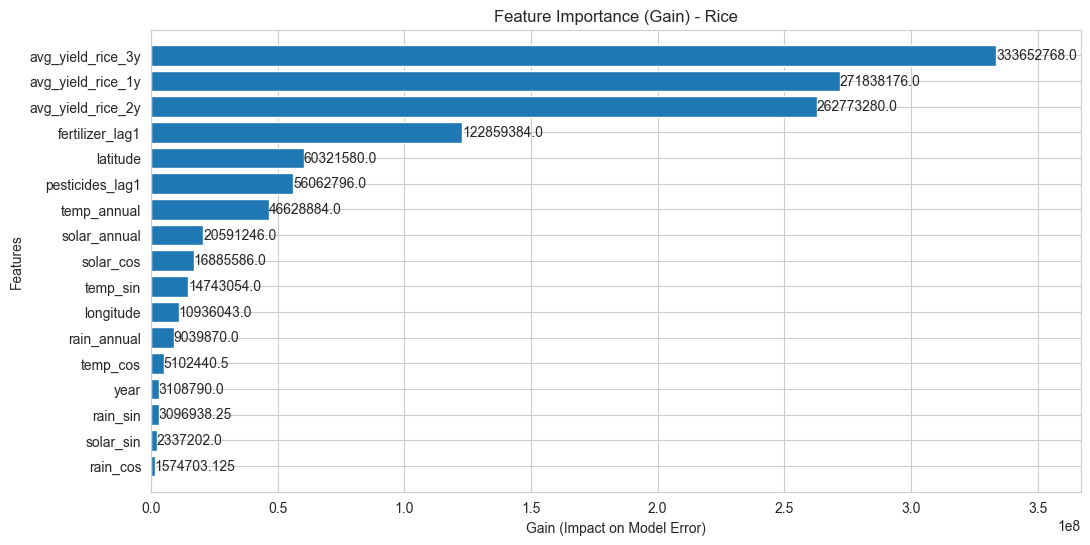

In [46]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances
importances = final_model.feature_importances_
feature_names = final_model.feature_names_in_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use XGBoost's built-in plotter
xgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    height=0.8,
    xlabel='Gain (Impact on Model Error)',
    title=f'Feature Importance (Gain) - {CHOSEN_CROP.capitalize()}'
)
plt.show()